## Kickstarter

Получаваме датасет с проекти в Kickstarter. Интересуваме се дали проекта ще бъде успешен или не. Какво точно значи "успешен проект" предстои да разберем. Първо малко библиотеки.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Обърнете внимание, че филтрираме FutureWarnings. Това са warning от тип "в тазия версия default параметър е това, но по-късно ще е онова". Когато е използван default параметър не е важно какъв е. Идеята е да се види как модела ще се справи горе-долу, евентуално после ще се конфигурира.

## Данни
Прочитаме файла от kaggle. Той има около 200-300 хиляди реда, затова използваме параметър nrows.

In [2]:
df = pd.read_csv("ks-projects-201801.csv", nrows=5000)
df.shape

(5000, 15)

In [3]:
df.head (5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Фйчърите не са много разнообразни. Преди да ги разгледаме по-дълбоко, нека да се справим с липсващи данни

In [4]:
df.isna().sum(axis=0)

ID                   0
name                 0
category             0
main_category        0
currency             0
deadline             0
goal                 0
launched             0
pledged              0
state                0
backers              0
country              0
usd pledged         53
usd_pledged_real     0
usd_goal_real        0
dtype: int64

За някой проекти нямаме `usd pledged`, въпреки че полетата `pledged` и `usd_pledged_real` са попълнени. Понеже са пренебрежимо малко, ще махнем съответните редове.

In [5]:
df = df.dropna(axis=0)
df.shape

(4947, 15)

По-късно ще логаритмуваме, което значи ще пак ще трябва да махаме данни от data frame-а. Сега е добър момент. Когато приключим ще реиндиксираме data frame-а, така че да няма проблеми на по-късен етап. След като реиндексираме **няма да променяме повече data frame-а**.

In [6]:
noBackers = sum (df.backers <= 0)
total = df.shape[0]

print ("projects with no backers:", noBackers)
print (noBackers/total, " of the population")

projects with no backers: 678
0.13705275924802912  of the population


Това е доста голяма част от популацията. Въпреки това ще я игнорираме, понеже за нея има тривиален модел -- ако никой не е
подпрепил проекта, то *най-вероятно* и проекта не е сполучил.

In [7]:
df = df[df.backers > 0]

Нека да направи същото и за `goal`. Много верояно няма проекти с `goal=0`, не пречи да се застраховаме.

In [8]:
noGoal = sum ((df.goal <= 0) | (df.usd_goal_real<=0))
total = df.shape[0]

print ("projects with no goal:", noGoal)
print (noGoal/total, " of the population")

projects with no goal: 0
0.0  of the population


Сега `pledged`. Тъй като филтрираме всички проекти, които никой не ги е подкрепил, най-верояно и тук няма да
намерим нищо за филтриране.

In [9]:
noPledged = sum ((df.pledged <= 0) | (df.usd_pledged_real<=0))
total = df.shape[0]

print ("projects with nothing pledged:", noPledged)
print (noPledged/total, " of the population")

projects with nothing pledged: 0
0.0  of the population


## Какво значи проект да е успешен?

Да видим какво представлява състояние на проект:

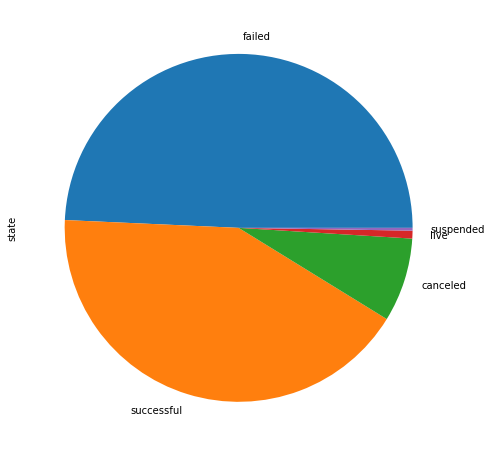

In [10]:
df.state.value_counts().plot(kind="pie", figsize = (8, 8));

`suspended` и `live` все още не са приключили и съответно не ни помагат в самообучението.

In [11]:
df = df[(df.state!="suspended") & (df.state!="live")]
successful = df.state=="successful"
successful.rename ("successful")
df.drop (columns=["state"], inplace=True)
df['successful'] = successful

Готово. Преиндексираме и повече не махаме данни. Изглежда сякаш сме махнали доста данни, но всъщност мажоритета от тях са проекти, за който не е помогнал. Имаме и много тривиален модел - ако никой не е дарил, значи проекта не е успял. Този модел ще е разбира се с лоша точност: ~10%.

In [12]:
df.index = range (0, df.shape[0])
successful.index = range (0, successful.size)

print ("New shape", df.shape)
df.head(5)

New shape (4227, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful
0,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,US,100.0,2421.0,30000.0,False
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,220.0,220.0,45000.0,False
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,1.0,1.0,5000.0,False
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,14,US,1283.0,1283.0,19500.0,False
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,US,52375.0,52375.0,50000.0,True


## Data exploration

#### Category

Виждаме, че има категории и "главни категории". Да видим колко наброй са категориите

In [13]:
unique_categories = df.category.value_counts().size
print ("Unique categories:", unique_categories)

Unique categories: 152


Ще е трудно да ги plot-нем всичките. Вместо това нека видим 10 най-популярни

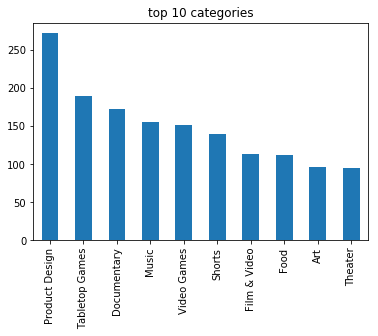

In [14]:
df.category.value_counts()[0:10].plot(kind="bar", title="top 10 categories");

Главните категории са по-малко и директно може да ги plot-нем

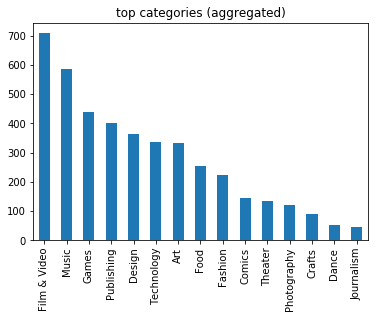

In [15]:
df.main_category.value_counts().plot(kind="bar", title="top categories (aggregated)");

Определено някой категории са по-чести от други. Забелязваме също, че има дублиране в `main_category` и `category`. После ще видим и вероятностите за успех.

#### Country

In [16]:
df.country.value_counts()

US    3273
GB     419
CA     177
AU      76
DE      47
IT      37
NL      36
FR      26
ES      23
MX      19
SE      18
NZ      12
IE      12
HK       9
BE       9
CH       8
DK       8
NO       7
AT       6
SG       4
LU       1
Name: country, dtype: int64

Пак ще се наложи да покажем най-поулярните

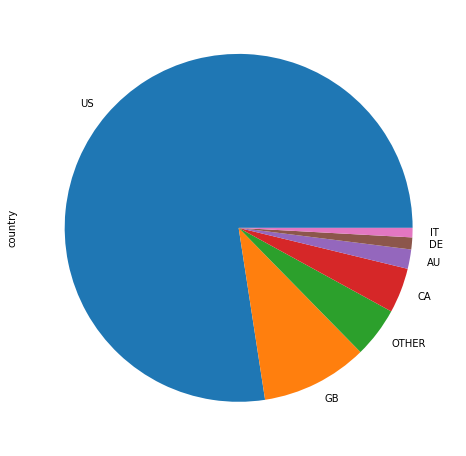

In [17]:
countryIndex = df.country.value_counts()[0:6].index
topCountry = df.country.apply (lambda x: x if countryIndex.contains (x) else "OTHER")
topCountry.rename ("country")
topCountry.value_counts().plot(kind="pie", figsize=(8, 8));

Ясно се вижда, че проектите в щатите доминират. На второ място идва Великобритания, след това Канада, Австралия и от там са горе-долу равностойно малцинство

#### Goal

`goal` е един от малкото числени feature-и. Всички те са с heavy tail дистрибуция и ще трябва да се постараем с plot-ването. За целта ще махнем част от опашката, като игнорираме 10% от най-голямите данни. Ще покажем и логаритмична трансформация.

In [18]:
df.goal.describe()

count    4.227000e+03
mean     3.725927e+04
std      6.674762e+05
min      1.000000e+00
25%      2.000000e+03
50%      5.000000e+03
75%      1.600000e+04
max      4.000000e+07
Name: goal, dtype: float64

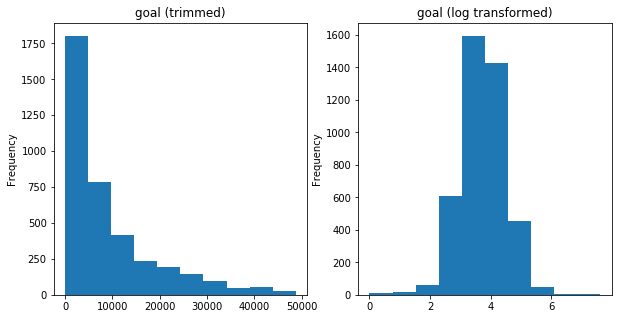

In [19]:
fig = plt.figure (figsize= (10, 5))
ax1 = fig.add_subplot (1, 2, 1)
ax2 = fig.add_subplot (1, 2, 2)

q = df.goal.quantile (0.9)
df.goal[df.goal < q].plot(kind="hist", title = "goal (trimmed)", ax=ax1);

np.log10(df.goal).plot(kind="hist", title = "goal (log transformed)", ax=ax2);


#### Pledged

Аналогично на `goal`. И заключенията са същите - heavy tail дистрибуция, но след log transform дистрибуцията наподобява нормална.

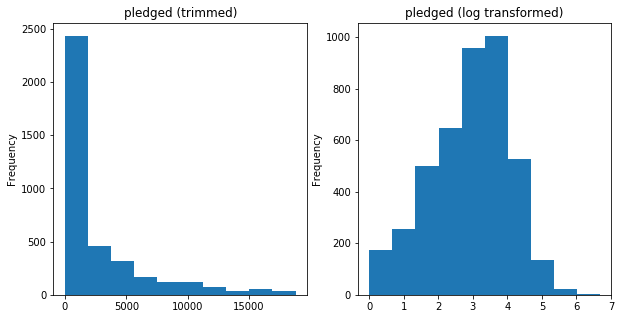

In [20]:
fig = plt.figure (figsize = (10, 5))
ax1 = fig.add_subplot (1, 2, 1)
ax2 = fig.add_subplot (1, 2, 2)

q = df.pledged.quantile (0.9)
df.pledged[df.pledged < q].plot(kind="hist", title = "pledged (trimmed)", ax=ax1);

np.log10(df.pledged).plot(kind="hist", title = "pledged (log transformed)", ax=ax2);

#### successful

От pie chart-а в началото видяхме, че вероятността за успех не е много голяма. Нека повторим процедурата, понеже трихме и промяхме feature-и.

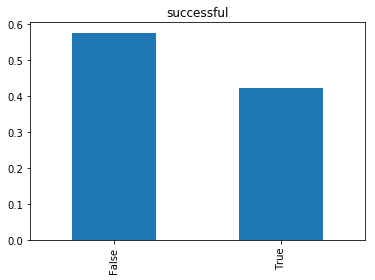

In [21]:
(df.successful.value_counts() / df.successful.size).plot(kind="bar", title="successful");

По-вероятно е проект да не е успешен. Трябва да внимаваме, когато правим train-test-split и също така, когато валидираме.

#### launch & deadline

Малко кофти за работа. Ще трябва да използваме библиотека `time`, за да се справим с тях. Нека да направим нов feature -- колко време продължава проект. Интуитивно, колкото повече, толково повече пари би събрал. Но пък след известно време хората спират да даряват и ако не е успял проекта в първите x дена, то вероятно и след година няма да успее. Освен това ако е с малък срок, хората би били по-мотивирани да дарят. Нека видим какво казват данните.

In [22]:
import time

def toSeconds (str):
    year = int(str[0:4])
    month = int(str[5:7])
    day = int(str[8:10])
    t = (year, month, day, 0, 0, 0, -1, -1, -1)
    return time.mktime (t)

duration = df.deadline.apply (toSeconds) - df.launched.apply(toSeconds)
duration = duration.apply (lambda x: x / 60 / 60 / 24)
duration = duration.rename ("duration")

Проверка дали не оплескахме нещо

In [23]:
pd.DataFrame ([df.launched, df.deadline, duration]).transpose().head(5)

,launched,deadline,duration
0,2017-09-02 04:43:57,2017-11-01,60.0417
1,2013-01-12 00:20:50,2013-02-26,45
2,2012-03-17 03:24:11,2012-04-16,29.9583
3,2015-07-04 08:35:03,2015-08-29,56
4,2016-02-26 13:38:27,2016-04-01,34.9583


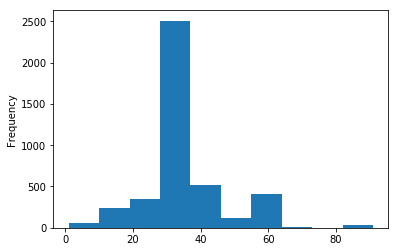

In [24]:
duration.plot(kind="hist");

Интересно. Разпределението изглежда горе-долу нормално с очакване 30 дни (един месец).

Да видим дали можем да направим някой друг feature engineering. Колко проекта има през годините? Има ли значение в кой ден от седмицата са стартирани? Ами месец в годината? Засега ще покажем само как Kickstarter
набира популярност през годините, а останалите feature-и по-късно ще разгледаме, така че да има някакъв ред.

In [25]:
print ("earliest launch:", df.launched.min())
print ("latest launch:", df.launched.max())

earliest launch: 2009-06-08 09:22:38
latest launch: 2017-12-19 07:32:41


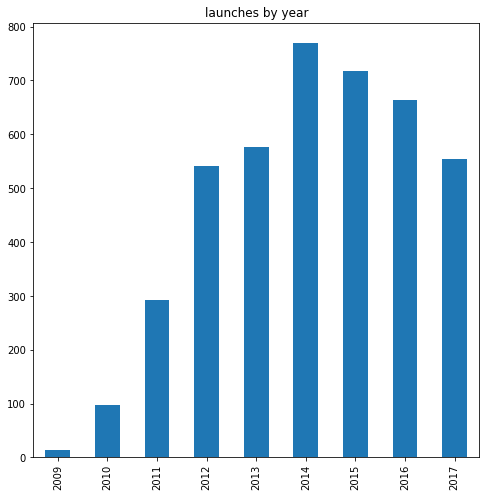

In [26]:
def toWeekday (x):
    secs = toSeconds (x)
    tm = time.gmtime(secs)
    return time.strftime ("%a", tm)

weekday = df.launched.apply (toWeekday)
weekday.rename ("weekday")

day = df.launched.apply (lambda x: int(x[8:10]))
day = day.rename ("day")

month = df.launched.apply (lambda x: int(x[5:7]))
month = month.rename ("month")

year = df.launched.apply (lambda x: int(x[0:4]))
year = year.rename ("year")

year.value_counts().sort_index().plot(kind="bar", figsize = (8, 8), title="launches by year");

До 2014 популярността е растяла, като през 2014 виждаме голям скок. След това леко е почнала да спада. Това е важно. Колкото повече проекти, толкова повече конкурениция. Но зависимостта може да е наобратно, понеже "много проекти" => "популярност на самата платформа" => "повече потенциални дарители"

#### currency

Този feature леко наподобява `country`. Човек би очаквал проект в щатите да е в щатски долари. Би било странно, ако не е.

In [27]:
df.currency.value_counts()

USD    3273
GBP     419
EUR     197
CAD     177
AUD      76
MXN      19
SEK      18
NZD      12
HKD       9
DKK       8
CHF       8
NOK       7
SGD       4
Name: currency, dtype: int64

In [28]:
df.country.value_counts()

US    3273
GB     419
CA     177
AU      76
DE      47
IT      37
NL      36
FR      26
ES      23
MX      19
SE      18
NZ      12
IE      12
HK       9
BE       9
CH       8
DK       8
NO       7
AT       6
SG       4
LU       1
Name: country, dtype: int64

Определено има зависимост. Вече когато стигнем до по-малко популярните страни виждаме, че валутите се разпръсват. Това ни казва, че
може да drop-нем каква валута използват проектите. Тя почти еднозначно се определя от страната.

#### backers
Още един числен feature. Подлагаме го на стандартната процедура.

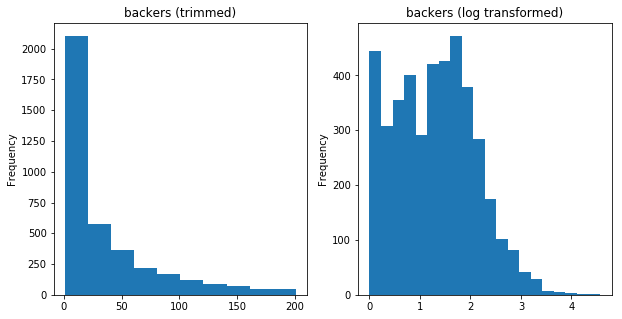

In [29]:
fig = plt.figure (figsize = (10, 5))
ax1 = fig.add_subplot (1, 2, 1)
ax2 = fig.add_subplot (1, 2, 2)

q = df.backers.quantile (0.9)
df.backers[df.backers < q].plot(kind="hist", title = "backers (trimmed)", ax=ax1);

np.log10(df.backers).plot(kind="hist", bins=20, title = "backers (log transformed)", ax=ax2);

Тук разпределението е подобно като другите целочислени feature-и с аномалия между 0 и 10. Виждаме подобна тенденция като проектите, които никой не е подкрепил. Да разследваме.

Projects with less than 10 backers: 0.38963804116394607


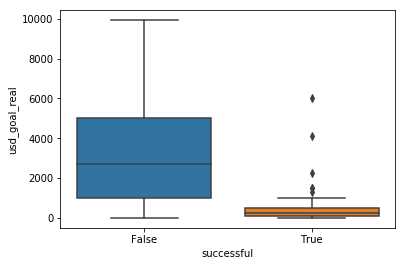

In [30]:
bv = df.backers <= 10
print ("Projects with less than 10 backers:", sum(bv)/df.backers.size)

threshold = 10000
sns.boxplot (x="successful", y="usd_goal_real", data=df[bv & (df.usd_goal_real<threshold)]);

In [31]:
df[bv].head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,220.00,220.00,45000.00,False
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,1.00,1.00,5000.00,False
14,1000070642,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02 14:11:32,250.0,7,US,250.00,250.00,250.00,True
17,1000081649,MikeyJ clothing brand fundraiser,Childrenswear,Fashion,AUD,2017-09-07,2500.0,2017-08-08 01:20:20,1.0,1,AU,0.00,0.81,2026.10,False
19,1000087442,Mountain brew: A quest for alcohol sustainability,Drinks,Food,NOK,2015-02-25,500.0,2015-01-26 19:17:33,48.0,3,NO,6.18,6.29,65.55,False
25,1000115172,Daily Brew Coffee,Food Trucks,Food,GBP,2015-03-31,3500.0,2015-03-01 18:06:32,21.0,1,GB,32.42,31.09,5181.12,False
33,1000134913,Galaxy: Winnie and Friends,Illustration,Art,USD,2016-01-27,3000.0,2015-12-23 21:47:29,17.0,2,US,17.00,17.00,3000.00,False
42,1000197321,(In)visible Empire Tees,Public Art,Art,USD,2016-01-02,1200.0,2015-11-22 22:47:44,90.0,4,US,90.00,90.00,1200.00,False
44,100020143,H2O The Underwater Portraits,People,Photography,USD,2017-10-30,9500.0,2017-09-25 17:17:43,6.0,2,US,5.00,6.00,9500.00,False
45,1000202062,SkateFrames-Photo frame made from recycled ska...,Art,Art,USD,2015-05-08,7500.0,2015-04-08 02:53:18,3.0,3,US,3.00,3.00,7500.00,False


Има доста такива проекти. Добрата вест е, че те или са много амбициозни, или лесно достижими, гледайки целта им.

#### usd pledged, usd_pledged_real, usd_goal_real

Тези feature-и са малко объркващи. Добра идея е да имаме някакъв вид обмен -- рублите и българските лева са доста различни и
линейната регресия няма да се радва, ако не й кажем как да ги различава. За random forest това не е точно така, но не можем да
разчитаме, че той ще е толкова умен.

Предоставен е interact widget, с който можем да променяме валутата и годината. Има три графики - една, която игнорира валутата и годината. Друга, която взима предвид само валутата и последно такава, която взима предвид и годината. Целта на widget-а е да се
убедим, че става въпрос за смяна на валутата, понеже в kaggle не беше съвсем пояснено.

In [32]:
def plotConversions (feature, currency, when):
    fig = plt.figure (figsize=(13, 12))
    ax1 = fig.add_subplot (3, 1, 1)
    ax2 = fig.add_subplot (3, 1, 2)
    ax3 = fig.add_subplot (3, 1, 3)
    
    sns.regplot (ax=ax1, x="pledged", y=feature, data=df);
    bv = df.currency==currency
    sns.regplot (ax=ax2, x="pledged", y=feature, data=df[bv]);
    bv &= year==when
    sns.regplot (ax=ax3, x="pledged", y=feature, data=df[bv]);

featureDropdown = ['usd_pledged_real', 'usd pledged']
currencyDropdown = df.currency.value_counts().index.get_values()
interact (plotConversions, feature=featureDropdown, currency=currencyDropdown,
          when=widgets.IntSlider(min=year.min(), max=year.max(), value=2014));

interactive(children=(Dropdown(description='feature', options=('usd_pledged_real', 'usd pledged'), value='usd_…

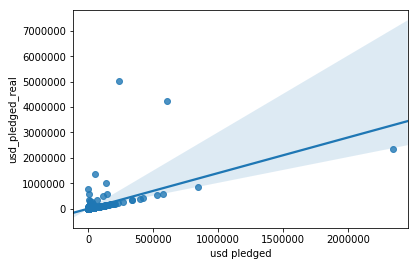

In [33]:
sns.regplot (x="usd pledged", y="usd_pledged_real", data=df);

Стана ясно какво представляват `usd pledged` и `usd_pledged_real` индивидуално, не и в какво се състои разликата.
В kaggle пише, че това разликата между двете е в определянето
на курса. Данните не показват точно това.

## Feature importance

Да видим каква е вероятността за успех според стойността на отделните feature-и.

#### launch

Ще разгледаме подробно за зависимост в деня, месеца, годината и седмичен ден.

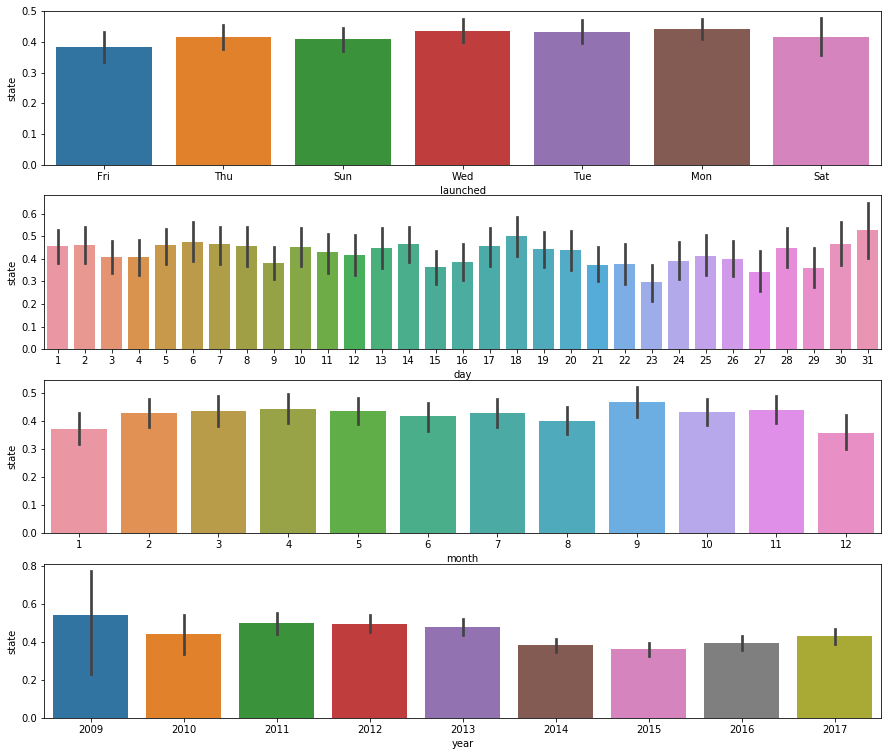

In [34]:
fig = plt.figure (figsize=(15, 13))
ax1 = fig.add_subplot (4, 1, 1)
ax2 = fig.add_subplot (4, 1, 2)
ax3 = fig.add_subplot (4, 1, 3)
ax4 = fig.add_subplot (4, 1, 4)

sns.barplot(ax=ax1, x=weekday, y=successful);
sns.barplot(ax=ax2, x=day, y=successful);
sns.barplot(ax=ax3, x=month, y=successful);
sns.barplot(ax=ax4, x=year, y=successful);

Заключваме, че кой точно е деня не е от значение. Така и така проектите са с около месец продължителност и дори някой да публикува
в "неподходящ момент", то всеки друг проект ще мине през този неподходящ момент (например към края на месеца). Деня от седмицата
също не показва ефект върху данните, вероятно по същата причина.

Кой месец е като че ли има значение. Юли, август, и декември не са случайни месеци - юли и август на море, а около декември има много празници. Ще включим съответен feature.

Годината също влияние. Хипотезата ни беше вярна - през 2014 се наблюдава спад и не случайно леко се покачва до 2017.

## category & main_category

Да проверим отделните вероятности и дали наистина можем да drop-нем main_category.

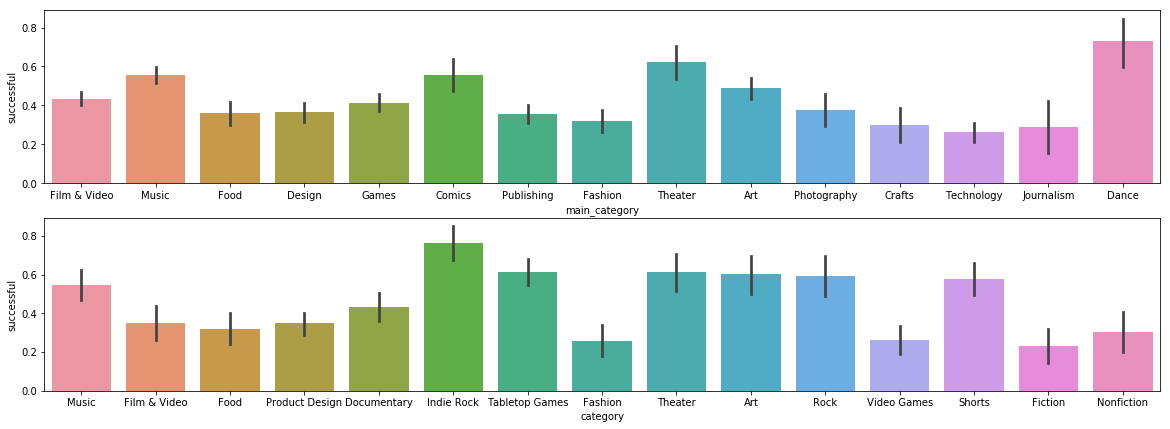

In [35]:
fig = plt.figure (figsize=(20, 7))
ax1 = fig.add_subplot (2, 1, 1)
ax2 = fig.add_subplot (2, 1, 2)

sns.barplot (ax=ax1, x="main_category", y="successful", data=df);

categoryIndex = df.category.value_counts()[0:15].index
bv = [categoryIndex.contains(x) for x in df.category]
sns.barplot (ax=ax2, x="category", y="successful", data=df[bv]);

Категорията е важна. Тук може би се изразява най-голяма разлика между отделните стойности на feature-ите.
Много от имената се повтарят между `category` и `main_category`. Вероятностите им са подобни. Това ни подсказва да
drop-нем `main_category`, понеже не ни казва нищо ново.

#### duration

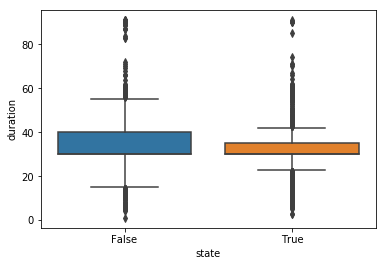

In [36]:
sns.boxplot(x=successful, y=duration);

Проектите, който са успешни, са с по-малка дисперсия от другите. Да разгледаме duration-а на успешните проекти

In [37]:
duration[successful].describe()

count    1790.000000
mean       31.934800
std        11.303548
min         3.000000
25%        29.958333
50%        30.000000
75%        34.989583
max        90.958333
Name: duration, dtype: float64

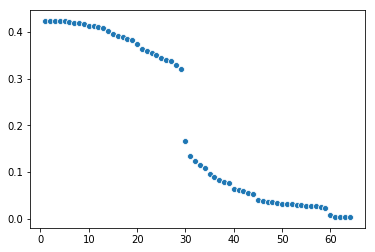

In [38]:
xs = range (1, 65)
ys = [successful[duration>x].sum() / (duration>x).size for x in xs]
sns.scatterplot(xs, ys);

In [39]:
print ("probability of success if project length is more than 29:", ys[28])
print ("probability of success if project length is more than 30:", ys[29])

probability of success if project length is more than 29: 0.3207948899929028
probability of success if project length is more than 30: 0.16702152827064112


Тази графика показва каква е вероятността проект да е успешен, ако той е с продължителност повече от x дни.
От x=10-30 дни виждаме бавен спад, но около x=30 има голям скок, вероятността почти пада двойно. Това ни подсказва
как точно да направим binning (в случай, че не използваме random forest)

#### country

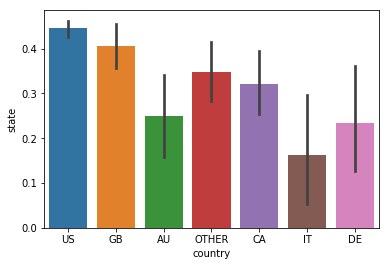

In [40]:
sns.barplot (x=topCountry, y=successful);

Мнго е важно от коя страна произлиза проекта, което е горе-долу очаквано.

#### goal, pledged, backers

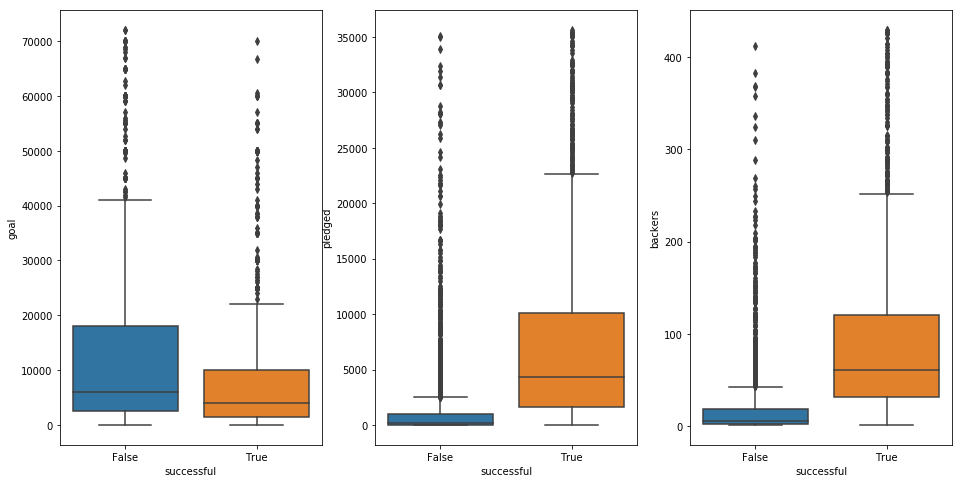

In [41]:
fig = plt.figure (figsize= (16, 8))
ax1 = fig.add_subplot (1, 3, 1)
ax2 = fig.add_subplot (1, 3, 2)
ax3 = fig.add_subplot (1, 3, 3)

bv = df.goal < df.goal.quantile (0.95)
sns.boxplot (ax=ax1, x="successful", y="goal", data=df[bv]);

bv = df.pledged < df.pledged.quantile (0.95)
sns.boxplot (ax=ax2, x="successful", y="pledged", data=df[bv]);

bv = df.backers < df.backers.quantile (0.95)
sns.boxplot (ax=ax3, x="successful", y="backers", data=df[bv]);

Бихме очаквали, че проекти с по-малък goal ще бъдът по-успешни, но уви. Разликата е малка в средната стойност, квантилите са по-близки. Но дистрибуцията е доста с по-тежка опашка -- това са някакви много известни проекти със сериозна финансова нужда

`pledged` пък отговаря повече на очакването. При това неуспешните проекти са събрали доста по-малко пари от успешните, въпреки че техния `goal` беше повече. Това значи, че голяма част от неуспешните проекти не им е достигнало доста.

Последно, виждаме, че `backers` оказва влияние. При това boxplot-овете са подобни на `pledged`. Toва ни води на мисълта
да пробваме нов feature -- `goal_per_backer` или колко пари трябва средно да даде човек, подкрепил проекта, така че той
да бъде успешен.

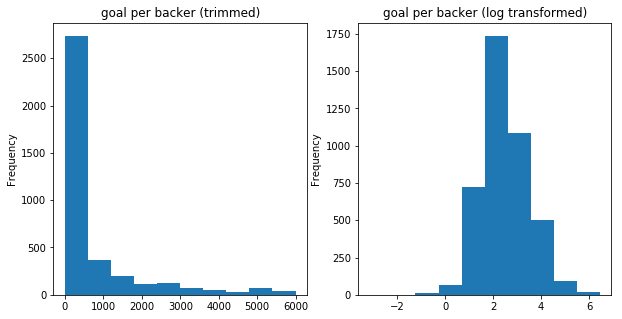

In [42]:
goalPerBacker = df.usd_goal_real / df.backers

fig = plt.figure (figsize = (10, 5))
ax1 = fig.add_subplot (1, 2, 1)
ax2 = fig.add_subplot (1, 2, 2)

q = goalPerBacker.quantile (0.9)
goalPerBacker[goalPerBacker < q].plot(kind="hist", title = "goal per backer (trimmed)", ax=ax1);

np.log10(goalPerBacker).plot(kind="hist", title = "goal per backer (log transformed)", ax=ax2);

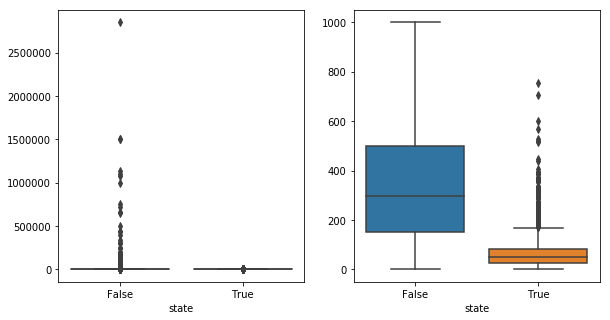

In [43]:
fig = plt.figure (figsize = (15, 5))
ax1 = fig.add_subplot (1, 3, 1)
ax2 = fig.add_subplot (1, 3, 2)

sns.boxplot (ax=ax1, x=successful, y=goalPerBacker);

bv = goalPerBacker < 1000
sns.boxplot (ax=ax2, x=successful[bv], y=goalPerBacker[bv]);

О, да. 1.5 милион долара на човек -- много далеч от истината. Трябва да ограничим boxplot-а до едва хиляда долъра на човек, което
пак е безумно, за да видим десния boxplot. 800 долара на човек? Сигурно са проекти с малко backer-и. Да видим какво ще
каже `describe`.

In [44]:
goalPerBacker[successful].describe()

count    1790.000000
mean       70.208089
std        79.742190
min         0.000667
25%        26.123643
50%        50.000000
75%        83.333333
max      1090.909091
dtype: float64

Изглежда разумно. Ще запазим този feature.

Нека проверим хипотезата, че един проект е успешен, ако е изпълнил своята парична цел.

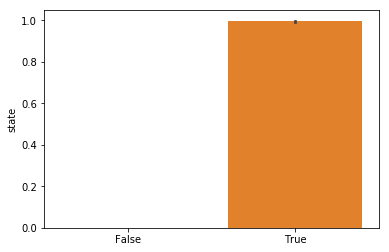

In [45]:
goalAchieved = df.pledged >= df.goal
sns.barplot (x=goalAchieved, y=successful);

Супер. Вече знам какво да правим с feature-ите. Последен плот...

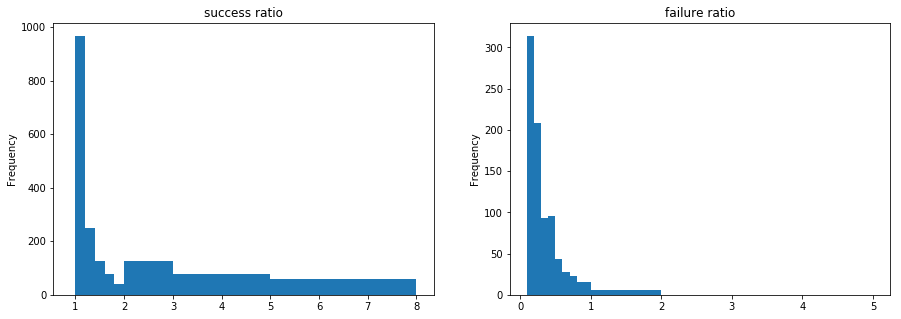

In [46]:
ratio = df.pledged / df.goal

fig = plt.figure (figsize = (15, 5))
ax1 = fig.add_subplot (1, 2, 1)
ax2 = fig.add_subplot (1, 2, 2)

ratio[df.successful].plot(ax=ax1, kind="hist",
                          bins=[0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 5, 8],
                          title="success ratio");

ratio[~df.successful].plot(ax=ax2, kind="hist",
                           bins=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 5],
                                 title="failure ratio");

Все пак е възможно проект да е събрал пари, но да не е успешен.

Ако проект е събрал пари, то с много голяма вероятност ще е близо до целта. Ако проект не е събрал пари, то вероятно е далече от
крайната цел.

## baseline model

От data exploration-а разбрахме кои са най-важните feature-и -- `usd_goal_real` и `backers`. Знаем, че искаме
да предскажем successful - дали проект е успешен или не. Знаем, че един проект да е успешен означава да е достигнал
своята цел. Следователно ще се наложи да drop-нем и pledged feature-ите. Освен класификатор, може да направим и регресор,
който предсказва колко пари един проект ще изкара.

Да започнем с baseline модел.

In [47]:
X_baseline = df[['usd_goal_real', 'backers']]
y = successful

X_baseline.head (5)

,usd_goal_real,backers
0,30000.0,15
1,45000.0,3
2,5000.0,1
3,19500.0,14
4,50000.0,224


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, stratify=y, random_state=515)
model = RandomForestClassifier(random_state=155).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.9766561514195583
test score:  0.8845789971617786


Никак зле! Да намерим по-добри параметри от default.

In [49]:
from sklearn.model_selection import GridSearchCV

def gridSearchRf (X, y, params={'n_estimators': [10, 30, 50, 70, 100], 'max_depth': [2, 4, 6, 8, 10, 12, 15]}):
    search = GridSearchCV(model, params)
    search.fit(X, y)
    return pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

In [50]:
gridSearchRf (X_baseline, y)

,rank_test_score,mean_test_score,params
13,1,0.906317,"{'max_depth': 6, 'n_estimators': 70}"
10,2,0.906080,"{'max_depth': 6, 'n_estimators': 10}"
12,3,0.905843,"{'max_depth': 6, 'n_estimators': 50}"
11,4,0.905370,"{'max_depth': 6, 'n_estimators': 30}"
8,5,0.905134,"{'max_depth': 4, 'n_estimators': 70}"
9,6,0.904424,"{'max_depth': 4, 'n_estimators': 100}"
6,7,0.904187,"{'max_depth': 4, 'n_estimators': 30}"
14,7,0.904187,"{'max_depth': 6, 'n_estimators': 100}"
7,9,0.903714,"{'max_depth': 4, 'n_estimators': 50}"
5,10,0.903004,"{'max_depth': 4, 'n_estimators': 10}"


In [51]:
model = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=155).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.9422712933753943
test score:  0.8997161778618732


Сега да пробваме с `goal_per_backer`.

In [52]:
X_baseline = X_baseline.assign (goal_per_backer=lambda x: x.usd_goal_real / x.backers)
gridSearchRf (X_baseline, y)

,rank_test_score,mean_test_score,params
8,1,0.911048,"{'max_depth': 4, 'n_estimators': 70}"
6,2,0.910811,"{'max_depth': 4, 'n_estimators': 30}"
7,3,0.910575,"{'max_depth': 4, 'n_estimators': 50}"
9,4,0.910102,"{'max_depth': 4, 'n_estimators': 100}"
5,5,0.908682,"{'max_depth': 4, 'n_estimators': 10}"
14,6,0.907026,"{'max_depth': 6, 'n_estimators': 100}"
13,7,0.906553,"{'max_depth': 6, 'n_estimators': 70}"
11,7,0.906553,"{'max_depth': 6, 'n_estimators': 30}"
12,9,0.906317,"{'max_depth': 6, 'n_estimators': 50}"
10,10,0.904424,"{'max_depth': 6, 'n_estimators': 10}"


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, stratify=y, random_state=515)
model = RandomForestClassifier(max_depth=8, n_estimators=70, random_state=155).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.9429022082018927
test score:  0.9044465468306528


Определено има подобрение, но е минимално. Ще запазим този модел както си е. Нека сега да добавим и категорийните feature-и.

## categorical data

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def oneHotEncode (x):
    le = LabelEncoder().fit(x)
    columns = le.inverse_transform (range (0, le.classes_.size))
    labelEncoded = le.transform(x)
    
    oneHotEncoded = OneHotEncoder().fit_transform(labelEncoded.reshape (labelEncoded.size, 1))
    return pd.DataFrame (data=oneHotEncoded.todense(), columns=columns)

In [55]:
categoryEncoded = oneHotEncode (df.category)
countryEncoded = oneHotEncode (df.country)

X_cat = pd.concat ([categoryEncoded, countryEncoded], axis=1)
X_cat.head(5)


,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,Architecture,...,IE,IT,LU,MX,NL,NO,NZ,SE,SG,US
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Не пречи да видим как ще се справи с тази ограничена информация. Няма да търсим добри параметри, не очакваме да се справи
блестящо.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, stratify=y, random_state=515)

model = RandomForestClassifier(random_state=155).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.6936908517350158
test score:  0.6263008514664143


И сега да добавим baseline модела. Също така установихме, че `year`, `duration` не са за пренепрегване. Няма да
правим binning на duration понеже използваме random forest.

In [57]:
X_cat = pd.concat ([X_cat, X_baseline], axis=1)
X_cat['year'] = year
X_cat['duration'] = duration
X_cat['vacation'] = ((month==7) | (month==8) | (month==12)).astype("float")

X_cat.head(5)

,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,Architecture,...,NZ,SE,SG,US,usd_goal_real,backers,goal_per_backer,year,duration,vacation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,30000.0,15,2000.000000,2017,60.041667,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,45000.0,3,15000.000000,2013,45.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,5000.0,1,5000.000000,2012,29.958333,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,19500.0,14,1392.857143,2015,56.000000,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,50000.0,224,223.214286,2016,34.958333,0.0


In [58]:
gridSearchRf (X_cat, y)

,rank_test_score,mean_test_score,params
31,1,0.912231,"{'max_depth': 15, 'n_estimators': 30}"
32,2,0.910811,"{'max_depth': 15, 'n_estimators': 50}"
28,3,0.910575,"{'max_depth': 12, 'n_estimators': 70}"
33,4,0.910102,"{'max_depth': 15, 'n_estimators': 70}"
27,5,0.909865,"{'max_depth': 12, 'n_estimators': 50}"
26,6,0.909155,"{'max_depth': 12, 'n_estimators': 30}"
24,6,0.909155,"{'max_depth': 10, 'n_estimators': 100}"
23,6,0.909155,"{'max_depth': 10, 'n_estimators': 70}"
29,9,0.908919,"{'max_depth': 12, 'n_estimators': 100}"
19,9,0.908919,"{'max_depth': 8, 'n_estimators': 100}"


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, stratify=y, random_state=515)
model = RandomForestClassifier(max_depth=15, n_estimators=100, random_state=155).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.9542586750788643
test score:  0.9091769157994324


Малко по-добре. Но все още не виждаме осезаемо подобрение.

Да разгледаме feature importance. Това ще ни помогне да разберем какво прави модела и в частност, какво не прави добре, за да
го подобрим. Но пък имаме доста feature-и и може нищо да не научим.

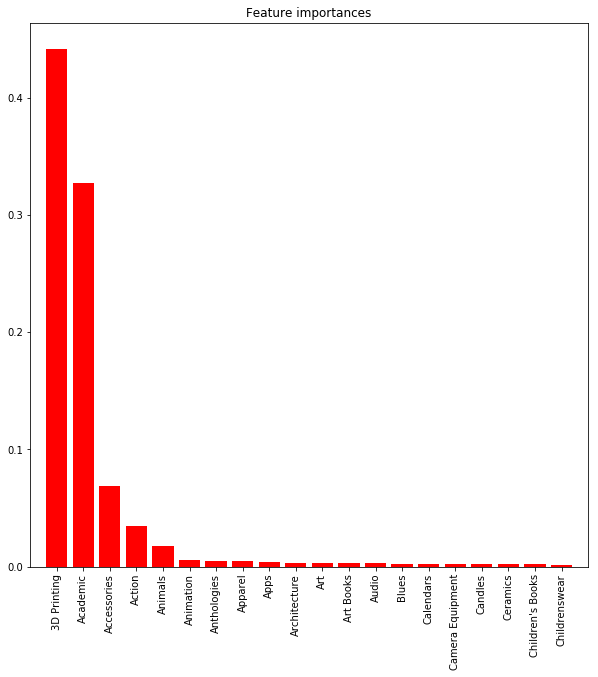

In [60]:
def random_forest_features(model, X, top=-1):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1][:top]
    
    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(indices.size), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(indices.size), X.columns, rotation='vertical')
    plt.xlim([-1, indices.size])
    plt.show()

random_forest_features(model, X_cat, top=20)

Категорията на проекта играе най-голяма роля. Това противоречи на предишния модел, който не се справи много добре, използвайки само категорията. Нищо не научихме. Да видим и confusion matrix.

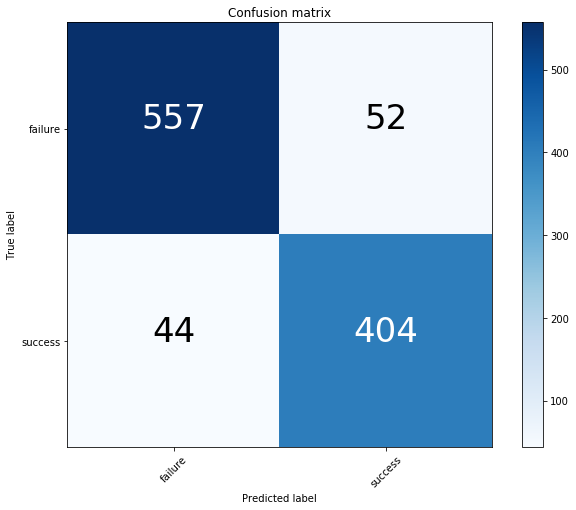

In [61]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(y_test, model.predict(X_test), classes=['failure', 'success'])

Изглежда балансирано.

## logistic regression model

Логистичната регресия може да даде по-добри резултати. Да пробваме. За целта обаче трябва да логаритмуваме числените
feature-и -- всички те показаха доста голям heavy tail distribution. Също така ще трябва да bin-нем duration, понеже
както видяхме проект с продължителност 30 дни не е два пъти по-зле от проект с продължителност 60 дни. За binning ще използваме
`[1, 30]`, `[31,  45]`, `[46, 60]`, `[61, inf)` като резултат от проучването ни.

In [62]:
X_log = X_cat.copy()
X_log.goal_per_backer = np.log(X_log.goal_per_backer)
X_log.backers = np.log(X_log.backers)
X_log.usd_goal_real = np.log(X_log.usd_goal_real)

X_log.drop(columns=['duration'])
durationBinned = pd.cut(duration, bins=[-1, 30, 45, 60, duration.max()],
                        labels=["duration_less_month", "duration_between_months", "duration_two_months", "duration_too_long"])
durationEncoded = oneHotEncode (durationBinned)
X_log = pd.concat ([X_log, durationEncoded], axis=1)
X_log.head(5)

,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,Architecture,...,usd_goal_real,backers,goal_per_backer,year,duration,vacation,duration_between_months,duration_less_month,duration_too_long,duration_two_months
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.308953,2.708050,7.600902,2017,60.041667,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.714418,1.098612,9.615805,2013,45.000000,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.517193,0.000000,8.517193,2012,29.958333,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.878170,2.639057,7.239112,2015,56.000000,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.819778,5.411646,5.408132,2016,34.958333,0.0,1.0,0.0,0.0,0.0


In [63]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_log, y, stratify=y, random_state=515)
model = LogisticRegression().fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.9252365930599369
test score: 0.9176915799432356


Абсолютно същия резултат. Тъжно. Да разгледаме feature importance.

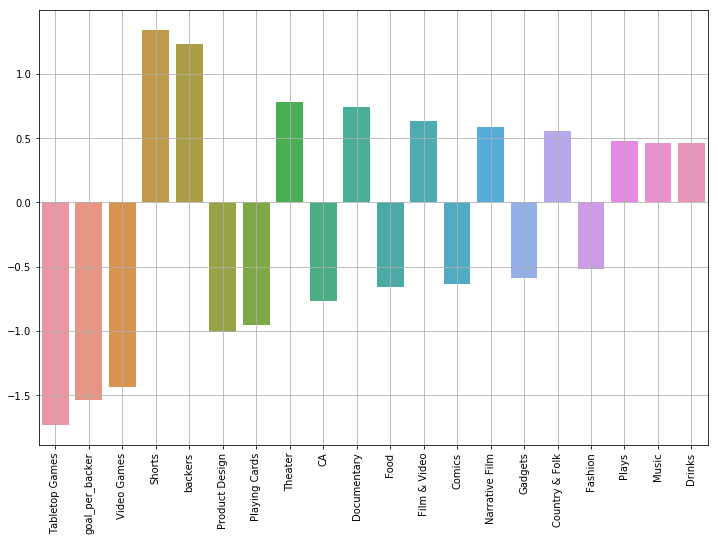

In [64]:
def logistic_regression_features(X, model, top=-1):
    indices = np.argsort(np.absolute(model.coef_[0]))[::-1][:top]
    plt.figure(figsize=(12,8))
    barplot = sns.barplot(x=X.columns[indices], y=model.coef_[0][indices], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)
    
logistic_regression_features(X_log, model, top=20)

Тук има повече смисъл. Виждаме най-важните feature-и имат голямо тегло, при това с правилна пропориця.

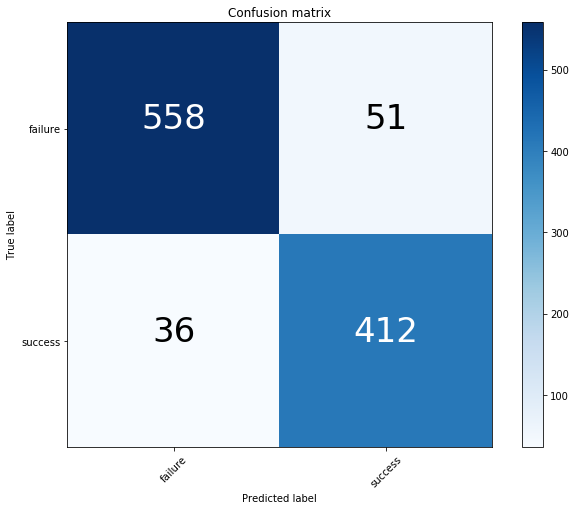

In [65]:
plot_confusion_matrix(y_test, model.predict(X_test), classes=['failure', 'success'])

И този модел изглежда симетричен.

Сега да разгледаме колко уверени са в себе си моделите.

## model probability

In [66]:
def probaDataFrame (X_test, model):
    proba = pd.DataFrame (data=model.predict_proba(X_test),
                          columns=['prob_failure', 'prob_success'], index=X_test.index)
    proba['guess'] = model.predict(X_test)
    proba = pd.concat ([df.iloc[proba.index], proba], axis=1)
    proba = proba.assign(goal_per_backer=lambda x: x.goal / x.backers)
    return proba

log_proba = probaDataFrame(X_test, model)
log_proba.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful,prob_failure,prob_success,guess,goal_per_backer
4033,1024301544,Season 1 of NYC Glitters,Webseries,Film & Video,USD,2011-12-01,6000.0,2011-10-14 20:16:11,1336.00,59,US,1336.00,1336.00,6000.00,False,0.334625,0.665375,True,101.694915
2454,1015025906,The Realize The Dream Project! A NEW EP and my...,Music,Music,USD,2013-07-21,11000.0,2013-06-21 14:00:44,11415.44,267,US,11415.44,11415.44,11000.00,True,0.010113,0.989887,True,41.198502
2466,1015075727,mariachi madness,Comedy,Film & Video,USD,2016-07-27,4250.0,2016-06-27 23:53:23,4367.00,74,US,2554.00,4367.00,4250.00,True,0.092866,0.907134,True,57.432432
1593,1009713929,Grump's Quest,Video Games,Games,GBP,2013-03-29,450000.0,2013-02-27 16:02:18,15800.00,40,GB,24007.20,24086.10,685996.52,False,0.999956,0.000044,False,11250.000000
60,1000260691,Gizbee™ Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25,87000.0,2016-02-29 20:30:27,2030.00,15,US,2030.00,2030.00,87000.00,False,0.999700,0.000300,False,5800.000000


In [67]:
bv = log_proba.guess!=log_proba.successful
log_proba[bv].head(15)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful,prob_failure,prob_success,guess,goal_per_backer
4033,1024301544,Season 1 of NYC Glitters,Webseries,Film & Video,USD,2011-12-01,6000.0,2011-10-14 20:16:11,1336.00,59,US,1336.00,1336.00,6000.00,False,0.334625,0.665375,True,101.694915
2680,1016332080,The Hinckley Brothers Are Making A New Record!,Country & Folk,Music,USD,2015-10-17,30000.0,2015-09-17 17:25:45,30395.01,74,US,30395.01,30395.01,30000.00,True,0.671047,0.328953,False,405.405405
2747,1016781421,Fantasy Funding,Children's Books,Publishing,GBP,2015-10-02,675.0,2015-08-13 14:54:48,236.00,16,GB,367.13,357.94,1023.78,False,0.308950,0.691050,True,42.187500
2345,1014315497,Kickstart our Root Cellar. Feed our community!,Farms,Food,USD,2015-07-15,25000.0,2015-06-15 15:00:31,13412.00,173,US,13412.00,13412.00,25000.00,False,0.186031,0.813969,True,144.508671
3280,1019959738,"""Welcome to Unity"" Booster Club (Canceled)",Documentary,Film & Video,USD,2014-07-05,30000.0,2014-05-17 02:56:12,4932.70,109,US,4932.70,4932.70,30000.00,False,0.371332,0.628668,True,275.229358
1115,1006835138,"Oh, Fudge!",Food,Food,USD,2011-11-16,5000.0,2011-09-17 03:51:54,1440.55,63,US,1440.55,1440.55,5000.00,False,0.306168,0.693832,True,79.365079
1346,1008111784,Megan Swansen Spring 2013,Fashion,Fashion,USD,2012-09-30,3000.0,2012-08-25 05:21:42,3068.00,28,US,3068.00,3068.00,3000.00,True,0.514415,0.485585,False,107.142857
229,1001188527,Design Your Own Leatherjacket,Fashion,Fashion,EUR,2016-06-14,2000.0,2016-05-29 22:04:54,2028.00,7,DE,2254.15,2282.32,2250.81,True,0.975990,0.024010,False,285.714286
1372,1008284937,Captain Pancake,Theater,Theater,GBP,2013-11-22,4000.0,2013-10-23 19:06:10,1376.00,46,GB,2219.13,2229.24,6480.36,False,0.180365,0.819635,True,86.956522
1092,1006670860,PRAISE,Performance Art,Art,USD,2013-08-07,1800.0,2013-06-28 21:51:52,596.00,18,US,596.00,596.00,1800.00,False,0.430862,0.569138,True,100.000000


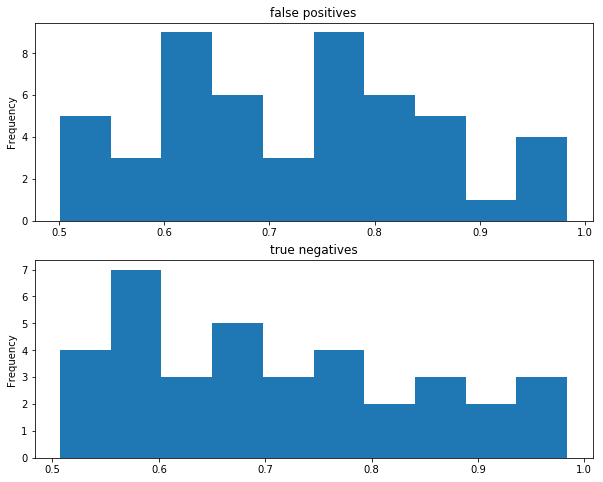

In [68]:
fig = plt.figure (figsize=(10, 8))
ax1 = fig.add_subplot (2, 1, 1)
ax2 = fig.add_subplot (2, 1, 2)

falsePositives = log_proba[(log_proba.guess==True) & (log_proba.successful==False)]
falsePositives.prob_success.plot(ax=ax1, kind="hist", title="false positives");

trueNegatives = log_proba[(log_proba.guess==False) & (log_proba.successful==True)]
trueNegatives.prob_failure.plot(ax=ax2, kind="hist", title="true negatives");

Логистичната регресия изглежда много уверена, въпреки че е много далеч от истината. Лошо. Но пък когато се разгледат примерите, в
които грешки, наистина не може да се каже защо греши. Няма как да научим по-добре регресията с належащите данни, само може
да правим малки инкрементални подобрения.

Сега и за random forest:

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, stratify=y, random_state=515)
model = RandomForestClassifier(max_depth=8, n_estimators=30, random_state=155).fit(X_train, y_train)
cat_proba = probaDataFrame(X_cat, model)
cat_proba.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful,prob_failure,prob_success,guess,goal_per_backer
0,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,US,100.0,2421.0,30000.0,False,0.864928,0.135072,False,2000.000000
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,220.0,220.0,45000.0,False,0.850495,0.149505,False,15000.000000
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,1.0,1.0,5000.0,False,0.804275,0.195725,False,5000.000000
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,14,US,1283.0,1283.0,19500.0,False,0.874851,0.125149,False,1392.857143
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,US,52375.0,52375.0,50000.0,True,0.531589,0.468411,False,223.214286


In [70]:
bv = cat_proba.guess!=cat_proba.successful
cat_proba[bv].head(15)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful,prob_failure,prob_success,guess,goal_per_backer
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,224,US,52375.00,52375.00,50000.00,True,0.531589,0.468411,False,223.214286
12,1000064918,The Beard,Comic Books,Comics,USD,2014-11-08,1500.0,2014-10-09 22:27:52,395.00,16,US,395.00,395.00,1500.00,False,0.416893,0.583107,True,93.750000
13,1000068480,Notes From London: Above & Below,Art Books,Publishing,USD,2015-05-10,3000.0,2015-04-10 21:20:54,789.00,20,US,789.00,789.00,3000.00,False,0.485097,0.514903,True,150.000000
15,1000071625,Boco Tea,Food,Food,USD,2012-06-02,5000.0,2012-05-03 17:24:32,1781.00,40,US,1781.00,1781.00,5000.00,False,0.432945,0.567055,True,125.000000
37,1000170964,Penny Bingo Playing Card Game fun for the whol...,Tabletop Games,Games,USD,2017-03-27,1500.0,2017-03-02 04:01:43,856.00,25,US,324.00,856.00,1500.00,False,0.250878,0.749122,True,60.000000
47,1000216800,Mothers Into Living Fit Yoga DVD for Moms and ...,Family,Film & Video,USD,2014-06-19,11000.0,2014-05-20 17:18:29,11055.00,51,US,11055.00,11055.00,11000.00,True,0.620338,0.379662,False,215.686275
56,1000243793,"""JurassicJurassix"" by The Guilt",Rock,Music,USD,2015-04-09,850.0,2015-02-23 00:10:28,485.00,13,US,485.00,485.00,850.00,False,0.486920,0.513080,True,65.384615
101,1000481607,Alpha Omega E.P.,Metal,Music,USD,2016-09-30,1000.0,2016-09-05 22:34:26,472.00,13,US,0.00,472.00,1000.00,False,0.372993,0.627007,True,76.923077
113,1000545028,Trackside - Independent documentary featuring ...,Documentary,Film & Video,GBP,2014-03-02,5000.0,2014-01-24 12:49:11,5037.00,47,GB,8345.98,8447.09,8385.04,True,0.639245,0.360755,False,106.382979
127,1000598804,Gone In 61 Seconds,Tabletop Games,Games,USD,2017-11-08,1000.0,2017-11-03 13:44:35,875.00,14,US,420.00,875.00,1000.00,False,0.421540,0.578460,True,71.428571


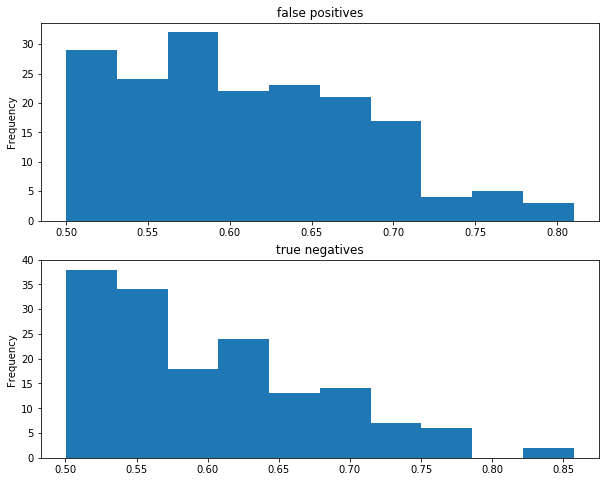

In [71]:
fig = plt.figure (figsize=(10, 8))
ax1 = fig.add_subplot (2, 1, 1)
ax2 = fig.add_subplot (2, 1, 2)

falsePositives = cat_proba[(cat_proba.guess==True) & (cat_proba.successful==False)]
falsePositives.prob_success.plot(ax=ax1, kind="hist", title="false positives");

trueNegatives = cat_proba[(cat_proba.guess==False) & (cat_proba.successful==True)]
trueNegatives.prob_failure.plot(ax=ax2, kind="hist", title="true negatives");

Random forest и linear regression моделите се справят горе-долу равно. Но графиката при random forest намаля за разлика от
логистичната регресия -- модела знае, когато не знае.

Липсвата на подобрение може би се дължи на липсата на данни - когато разгледаме ръчно в кой примери грешат, не можем да си дадем обяснение. Затова и stacking няма да има голям ефект.

## text feature

Дали `name` feature може да ни помогне?

In [72]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np

def plot_wordcloud_mask(words):
    plt.figure(figsize=(14,12))
    wc = WordCloud(background_color="black", max_words=10000,
                   stopwords=STOPWORDS, max_font_size= 40)
    wc.generate(" ".join(words))
    plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.axis('off');

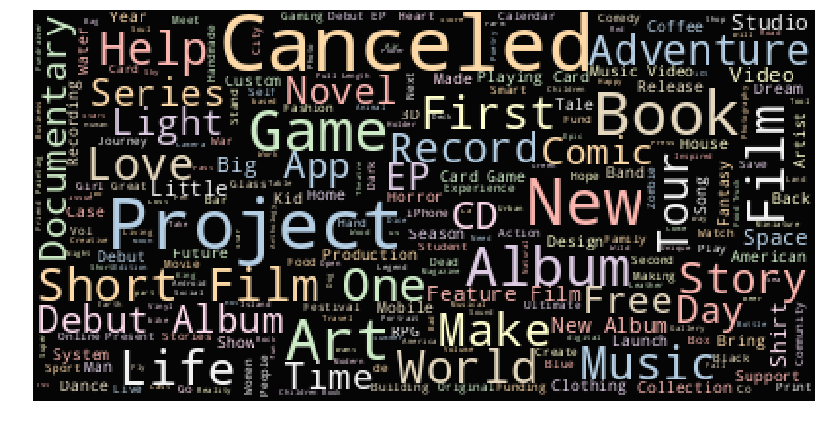

In [73]:
plot_wordcloud_mask(df.name)

Като че ли не. Все пак пробваме с CountVectorizer и Stemming

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import scipy.sparse

stem = PorterStemmer()
stemmed = df.name.apply(lambda t: " ".join([stem.stem(w) for w in t.split()]))

cntvec = CountVectorizer()
X_cntvec = scipy.sparse.hstack([cntvec.fit_transform(stemmed, successful),
                               scipy.sparse.csr_matrix(X_log.values)])

X_train, X_test, y_train, y_test = train_test_split(X_cntvec, y, stratify=y, random_state=515)
model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.9839116719242902
test score: 0.9167455061494797


Добре. Тук нарочно използвах sprase matrix, понеже получавам **memory error**. Сега ще е по-трудна работата с матрицата,
но иначе няма как.

Има известен проблем обаче. От wordcloud снимката се вижда, че част от проектите имат "canceled" в името си. Това нечестно подсказва на нашия модел и може да е причината точността да се е дигнала с 1%. Да филтрираме всички думи "cancelled".

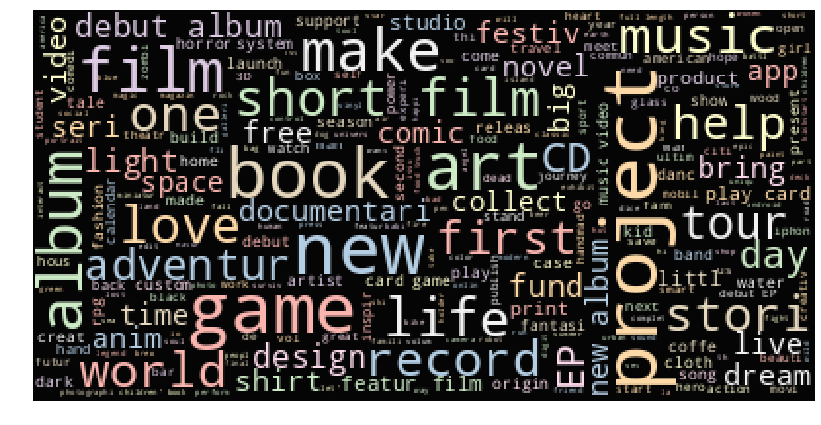

In [75]:
def removeCanceled (str):
    f = filter (lambda w: w.find("canceled")==-1, str.split())
    return " ".join (list(f))

nocanceled = stemmed.apply (removeCanceled)
plot_wordcloud_mask (nocanceled)

In [76]:
X_cntvec = scipy.sparse.hstack([cntvec.fit_transform(nocanceled, successful),
                               scipy.sparse.csr_matrix(X_log.values)])

X_train, X_test, y_train, y_test = train_test_split(X_cntvec, y, stratify=y, random_state=515)
model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.9826498422712934
test score: 0.9139072847682119


Bummer. Нека да добавим и няколко text feature-и.

In [77]:
import string

words = df.name.apply(lambda s: len(str(s).split()))
word_length = df.name.apply(lambda s: np.mean([len(w) for w in str(s).split()]))
symbols = df.name.str.len()
punctuation = df.name.apply(lambda s: sum([c in string.punctuation for c in str(s)]) )

X_cntvec = scipy.sparse.hstack ([X_cntvec,
                                 scipy.sparse.csr_matrix([words,
                                                          word_length,
                                                          symbols,
                                                          punctuation]).transpose()])

textFeatureMap = {"words": words, "word_length": word_length,
                  "symbols": symbols, "punctuation": punctuation}

def plotTextFeature (feature):
    plt.figure()
    sns.violinplot(x=successful, y=textFeatureMap[feature])
    plt.title(feature);

interact (plotTextFeature, feature=['words', 'word_length', 'symbols', 'punctuation']);

interactive(children=(Dropdown(description='feature', options=('words', 'word_length', 'symbols', 'punctuation…

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_cntvec, y, stratify=y, random_state=515)
model = LogisticRegression().fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.9817034700315458
test score: 0.9139072847682119


Няма подобрение, както и графиките показаха. Прочем нарочно използваме логистична регресия, защото random forest много
underfit-ва.

И последно tfidf. Няма да включваме новите feature-и. Труд на вятъра.

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer()
X_tfidf = scipy.sparse.hstack([tfidf.fit_transform(nocanceled),
                               scipy.sparse.csr_matrix(X_log.values)])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, stratify=y, random_state=515)
model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.9479495268138801
test score: 0.9205298013245033


Пак нямаше успех.


## Заключение

Можем много лесно да направим добър модел (0.91 accuray), но много трудно може да го подобрим. Random forest и логистична
регресия (с малки разлики при моделиране) се справят аналогично без текстови feature-и. С CountVectorization има малко подобрение при логистичната регресия, което се дължи на факта, че в името на проекта може да има canceled. Random forest модела знае, когато не знае. Тоест, вероятността да познае грешно намаля постепенно с увеличение на model.proba стойността. При всички случай не успяхме да получим повече от 0.93 accuracy.

При ръчен преглед на проектите, който класифицираме грешно, няма някакъв pattern защо грешим -- някой проекти звучат абсурдно да са
събрали пари, други пък съвсем резонно и модела ни прави логично решение, но все пак греши.